In [1]:
import torch
import torch_geometric
from torch_geometric.data import Data, DataLoader
import deepchem as dc
from rdkit import Chem
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data, InMemoryDataset
import random
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch.optim.lr_scheduler import ReduceLROnPlateau

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\__init__.py)


In [2]:
import random
random_state = 42
random.seed(random_state)
torch.manual_seed(random_state)
np.random.seed(random_state)

In [3]:
import os
import shutil


base_path = os.getcwd()

parent_path = os.path.dirname(os.path.dirname(base_path))

data_path = os.path.join(parent_path, "data")
gae_data_path = os.path.join(data_path, "ARGA")
logistic_eq_path = os.path.join(gae_data_path, "logistic equation")
rule_of_three_path = os.path.join(gae_data_path, "rule of three")
fragrance_like_property = os.path.join(gae_data_path, "fragrance_like_property")
GDB_criteria = os.path.join(gae_data_path, "GDB Criteria")
if os.path.exists(gae_data_path):
    shutil.rmtree(gae_data_path)
    print(f"Deleted folder: {gae_data_path}")
else:
    print(f"Folder does not exist: {gae_data_path}")

os.makedirs(data_path, exist_ok=True)


os.makedirs(gae_data_path, exist_ok=True)


os.makedirs(logistic_eq_path, exist_ok=True)
os.makedirs(rule_of_three_path, exist_ok=True)
os.makedirs(fragrance_like_property, exist_ok=True)
os.makedirs(GDB_criteria, exist_ok=True)
print(f"Created folder structure:")
print(f"  {data_path}")
print(f"  {gae_data_path}")
print(f"  {logistic_eq_path}")
print(f"  {rule_of_three_path}")
print(f"  {fragrance_like_property}")

Deleted folder: c:\Users\sarab\OneDrive\Desktop\CSIR\generative_model_compare\data\ARGA
Created folder structure:
  c:\Users\sarab\OneDrive\Desktop\CSIR\generative_model_compare\data
  c:\Users\sarab\OneDrive\Desktop\CSIR\generative_model_compare\data\ARGA
  c:\Users\sarab\OneDrive\Desktop\CSIR\generative_model_compare\data\ARGA\logistic equation
  c:\Users\sarab\OneDrive\Desktop\CSIR\generative_model_compare\data\ARGA\rule of three
  c:\Users\sarab\OneDrive\Desktop\CSIR\generative_model_compare\data\ARGA\fragrance_like_property


In [4]:
from torch_geometric.data import InMemoryDataset, Data

class DeepChemToPyGDataset(InMemoryDataset):
    def __init__(self, data_list, transform=None):
        """
        Converts a list of PyG `Data` objects into an InMemoryDataset.
        
        Args:
            data_list (list of Data): List of PyG Data objects.
            transform (callable, optional): Optional transform applied to each data object.
        """
        super(DeepChemToPyGDataset, self).__init__('.', transform, None, None)
        self.data, self.slices = self.collate(data_list)

    def get(self, idx):
        """
        Retrieves the data object at the specified index.
        """
        return super().get(idx)


In [5]:

pyg_dataset = torch.load(r'C:\Users\sarab\OneDrive\Desktop\CSIR\generative_model_compare\data\curated dataset\cleaned_frag_pyg_dataset.pth')

C:\Users\sarab\AppData\Local\Temp\ipykernel_10572\918640251.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pyg_dataset = torch.load(r'C:\Users\sarab\OneDrive\Desktop\CS

In [6]:
# Setting up hyperparameters
node_features = pyg_dataset[0].x.shape[1] 
edge_features = pyg_dataset[0].edge_attr.shape[1] 
hidden_dim = 192
latent_dim = 64
lr=0.001258
num_epochs = 60
batch_size = 8
patience = 10


In [7]:

loader = DataLoader(pyg_dataset, batch_size=batch_size, shuffle=True)

c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [8]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool

class ARGA(nn.Module):
    def __init__(self, node_features, edge_features, hidden_dim, latent_dim, dropout=0.2):
        super(ARGA, self).__init__()
        self.encoder = Encoder(node_features, edge_features, hidden_dim, latent_dim, dropout)
        self.decoder = Decoder(latent_dim, hidden_dim, node_features, edge_features)
        self.discriminator = Discriminator(latent_dim, hidden_dim)
        
    def encode(self, x, edge_index, edge_attr, batch=None):
        return self.encoder(x, edge_index, edge_attr, batch)

    def decode(self, z, edge_index, batch=None):
        return self.decoder(z, edge_index, batch)

    def discriminate(self, z):
        return self.discriminator(z)

    def forward(self, x, edge_index, edge_attr, batch=None):
        z, mu = self.encode(x, edge_index, edge_attr, batch)
        reconstructed_x, reconstructed_edge_attr = self.decode(z, edge_index, batch)
        return reconstructed_x, reconstructed_edge_attr, z

    def generate_multiple_outputs(self, x, edge_index, edge_attr, batch=None, num_samples=5, variator=0.1):
        outputs = []
        with torch.no_grad():
            z, mu = self.encode(x, edge_index, edge_attr, batch)
            for _ in range(num_samples):
                epsilon = torch.randn_like(mu) * variator
                z_new = mu + epsilon
                reconstructed_x, reconstructed_edge_attr = self.decode(z_new, edge_index, batch)
                outputs.append((reconstructed_x, reconstructed_edge_attr, edge_index))
        return outputs

class Encoder(nn.Module):
    def __init__(self, node_features, edge_features, hidden_dim, latent_dim, dropout):
        super(Encoder, self).__init__()
        self.edge_encoder = nn.Linear(edge_features, hidden_dim)
        self.conv1 = SAGEConv(node_features + hidden_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr, batch=None):
        edge_attr = torch.clamp(edge_attr, -5, 5)
        edge_attr = F.relu(self.edge_encoder(edge_attr))
        edge_attr = self.dropout(edge_attr)
        
        edge_attr_expanded = torch.zeros((x.size(0), edge_attr.size(1)), device=x.device)
        edge_attr_expanded[edge_index[0]] = edge_attr
        
        x = torch.cat([x, edge_attr_expanded], dim=1)
        x = torch.clamp(x, -5, 5)
        
        h1 = self.conv1(x, edge_index)
        h1 = self.layer_norm1(h1)
        h1 = F.relu(h1)
        h1 = self.dropout(h1)
        
        h2 = self.conv2(h1, edge_index)
        h2 = self.layer_norm2(h2)
        h2 = F.relu(h2)
        h2 = self.dropout(h2)
        
        if batch is not None:
            h2 = global_mean_pool(h2, batch)
        
        mu = self.fc_mu(h2)
        log_var = self.fc_var(h2)
        log_var = torch.clamp(log_var, -10, 2)
        
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        return z, mu

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, node_features, edge_features):
        super(Decoder, self).__init__()
        self.node_decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, node_features)
        )
        
        self.edge_decoder = nn.Sequential(
            nn.Linear(latent_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, edge_features)
        )

    def forward(self, z, edge_index, batch=None):
        if batch is not None:
            z = z[batch]
        
        reconstructed_x = self.node_decoder(z)
        
        row, col = edge_index
        edge_h = torch.cat([z[row], z[col]], dim=1)
        reconstructed_edge_attr = self.edge_decoder(edge_h)
        
        return reconstructed_x, reconstructed_edge_attr

class Discriminator(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.net(z)

def train_arga_with_early_stopping(model, train_loader, val_loader, num_epochs, lr=0.0001, device='cuda', patience=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            reconstructed_x, reconstructed_edge_attr, z = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            
            recon_loss = F.mse_loss(reconstructed_x, batch.x) + F.mse_loss(reconstructed_edge_attr, batch.edge_attr)
            
            real_z = torch.randn_like(z)
            real_scores = model.discriminate(real_z)
            fake_scores = model.discriminate(z)
            
            adv_loss = -torch.mean(torch.log(torch.clamp(fake_scores, 1e-6, 1.0)) + 
                                 torch.log(torch.clamp(1 - real_scores, 1e-6, 1.0)))
            
            loss = recon_loss + 1 * adv_loss
            
            if not torch.isnan(loss) and not torch.isinf(loss):
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                total_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                reconstructed_x, reconstructed_edge_attr, _ = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
                val_loss += (F.mse_loss(reconstructed_x, batch.x) + 
                           F.mse_loss(reconstructed_edge_attr, batch.edge_attr)).item()
        
        val_loss /= len(val_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping triggered')
                break
    
    return model



In [9]:
from torch.utils.data import random_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initializing the ARGA model
model = ARGA(node_features, edge_features, hidden_dim=hidden_dim, latent_dim=latent_dim)
train_ratio = 0.8
num_train = int(len(pyg_dataset) * train_ratio)
num_valid = len(pyg_dataset) - num_train
train_dataset, valid_dataset = random_split(pyg_dataset, [num_train, num_valid])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)




In [10]:
trained_model = train_arga_with_early_stopping(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    lr=lr,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    patience=patience
)


Epoch 1/60, Loss: 0.1466, Val Loss: 0.0874
Epoch 2/60, Loss: 0.0901, Val Loss: 0.0870
Epoch 3/60, Loss: 0.0896, Val Loss: 0.0872
Epoch 4/60, Loss: 0.0893, Val Loss: 0.0867
Epoch 5/60, Loss: 0.0892, Val Loss: 0.0864
Epoch 6/60, Loss: 0.0889, Val Loss: 0.0865
Epoch 7/60, Loss: 0.0889, Val Loss: 0.0865
Epoch 8/60, Loss: 0.0889, Val Loss: 0.0866
Epoch 9/60, Loss: 0.0887, Val Loss: 0.0862
Epoch 10/60, Loss: 0.0888, Val Loss: 0.0861
Epoch 11/60, Loss: 0.0885, Val Loss: 0.0862
Epoch 12/60, Loss: 0.0886, Val Loss: 0.0861
Epoch 13/60, Loss: 0.0886, Val Loss: 0.0861
Epoch 14/60, Loss: 0.0885, Val Loss: 0.0862
Epoch 15/60, Loss: 0.0884, Val Loss: 0.0861
Epoch 16/60, Loss: 0.0886, Val Loss: 0.0861
Epoch 17/60, Loss: 0.0885, Val Loss: 0.0860
Epoch 18/60, Loss: 0.0965, Val Loss: 0.0863
Epoch 19/60, Loss: 0.0886, Val Loss: 0.0861
Epoch 20/60, Loss: 0.0883, Val Loss: 0.0860
Epoch 21/60, Loss: 0.0884, Val Loss: 0.0860
Epoch 22/60, Loss: 0.0884, Val Loss: 0.0859
Epoch 23/60, Loss: 0.0886, Val Loss: 0.08

In [11]:
model=trained_model

In [12]:

def decode_node_attributes(node_vector):
    
    valence_range = list(range(7)) + ['EXCEPTIONAL']
    degree_range = list(range(6)) + ['EXCEPTIONAL']
    num_hydrogens_range = list(range(5)) + ['EXCEPTIONAL']
    formal_charge_range = [-1, -2, 1, 2, 0, 'EXCEPTIONAL']
    atomic_num_range = list(range(1, 101)) + ['EXCEPTIONAL']
    hybridization_options = ['SP', 'SP2', 'SP3', 'SP3D', 'SP3D2', 'EXCEPTIONAL']

    
    valence = node_vector[:8]
    degree = node_vector[8:15]
    num_hydrogens = node_vector[15:21]
    formal_charge = node_vector[21:27]
    atomic_num = node_vector[27:128]
    hybridization = node_vector[128:]

    
    decoded_attributes = {
        'Valence': valence_range[np.argmax(valence)],
        'Degree': degree_range[np.argmax(degree)],
        'Number_of_Hydrogens': num_hydrogens_range[np.argmax(num_hydrogens)],
        'Formal_Charge': formal_charge_range[np.argmax(formal_charge)],
        'Atomic_Number': atomic_num_range[np.argmax(atomic_num)],
        'Hybridization': hybridization_options[np.argmax(hybridization)]
    }

    return decoded_attributes

def decode_node_matrix(node_matrix):
    return [decode_node_attributes(node) for node in node_matrix]




In [13]:
temp = pyg_dataset[0]

In [14]:

def decode_edge_attributes(edge_vector):
    
    bond_types = ["EXCEPTIONAL", "single", "double", "triple", "aromatic"]

    
    bond_type = edge_vector[:5]  
    is_in_ring = edge_vector[5]  

    
    decoded_attributes = {
        'Bond_Type': bond_types[np.argmax(bond_type)],
        'Is_in_Ring': bool(is_in_ring)
    }

    return decoded_attributes

def decode_edge_matrix(edge_matrix):
    return [decode_edge_attributes(edge) for edge in edge_matrix]

In [15]:

encoded_representations = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = model.to(device)
for i in pyg_dataset:
    temp = i
    x = temp.x.to(device)
    edge_index = temp.edge_index.to(device)
    edge_attr = temp.edge_attr.to(device)
    z, _ = model.encode(x, edge_index, edge_attr)
    
    encoded_representations.append(z.cpu().detach().numpy())
    


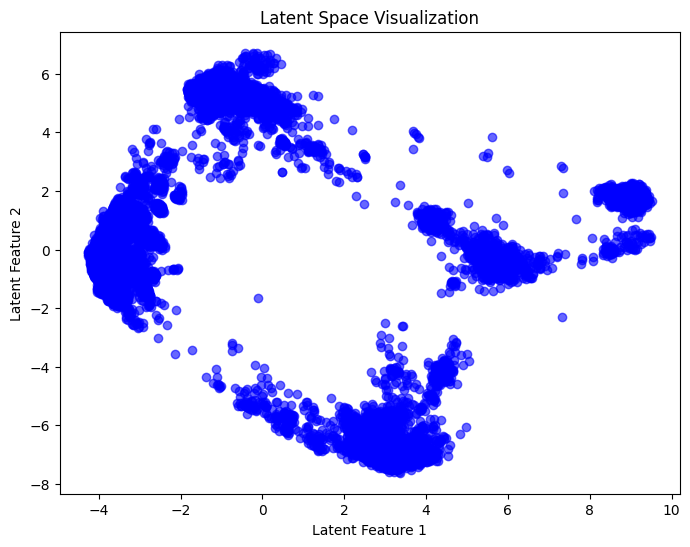

In [16]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
encoded_representations = np.concatenate(encoded_representations, axis=0)
if latent_dim > 2:
    pca = PCA(n_components=2)
    encoded_representations = pca.fit_transform(encoded_representations)


plt.figure(figsize=(8, 6))
plt.scatter(encoded_representations[:, 0], encoded_representations[:, 1], c='b', marker='o', alpha=0.6)
plt.title('Latent Space Visualization')
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
plt.show()

In [17]:
from tqdm import tqdm  


model.eval()


all_generated_outputs = []


num_samples = 5


successful_generations = 0


VARIATOR = 8




with torch.no_grad():
    for i in tqdm(range(len(pyg_dataset)), desc="Generating molecules"):
        try:
            batch = pyg_dataset[i]
            x, edge_index, edge_attr = batch.x.to(device), batch.edge_index.to(device), batch.edge_attr.to(device)
            generated_outputs = model.generate_multiple_outputs(x, edge_index, edge_attr, num_samples=num_samples, variator = VARIATOR)
            all_generated_outputs.extend(generated_outputs)
            successful_generations += 1
        except RuntimeError as e:
            print(f"Error processing molecule {i}: {str(e)}")
            continue

print(f"Successfully generated samples for {successful_generations} out of {len(pyg_dataset)} molecules.")
print(f"Total number of generated molecules: {len(all_generated_outputs)}")

Generating molecules: 100%|██████████| 4751/4751 [00:11<00:00, 414.87it/s]

Successfully generated samples for 4751 out of 4751 molecules.
Total number of generated molecules: 23755


In [18]:
from rdkit import Chem
from rdkit.Chem import rdchem

def create_rdkit_mol(node_attributes, edge_index, edge_attributes):
    mol = Chem.RWMol()

    hybridization_map = {
        'SP': rdchem.HybridizationType.SP,
        'SP2': rdchem.HybridizationType.SP2,
        'SP3': rdchem.HybridizationType.SP3,
        'SP3D': rdchem.HybridizationType.SP3D,
        'SP3D2': rdchem.HybridizationType.SP3D2
    }


    for node in node_attributes:
        atomic_num = node['Atomic_Number']
        atom = Chem.Atom(atomic_num)

        
        formal_charge = int(node.get('Formal_Charge'))
        atom.SetFormalCharge(formal_charge)

        hybridization = hybridization_map.get(node['Hybridization'], rdchem.HybridizationType.UNSPECIFIED)
        atom.SetHybridization(hybridization)

        
        mol_idx = mol.AddAtom(atom)

        
        try:
            num_hydrogens = int(node.get('Number_of_Hydrogens', 0))
        except ValueError:
            print(f"Invalid Number_of_Hydrogens value for node with atomic number {atomic_num}: {node.get('Number_of_Hydrogens')}. Setting to 0.")
            num_hydrogens = 0

        mol.GetAtomWithIdx(mol_idx).SetNumExplicitHs(num_hydrogens)

    
    for [i, j], edge in zip(edge_index, edge_attributes):
        bond_type = rdchem.BondType.SINGLE
        if edge['Bond_Type'] == 'double':
            bond_type = rdchem.BondType.DOUBLE
        elif edge['Bond_Type'] == 'triple':
            bond_type = rdchem.BondType.TRIPLE
        elif edge['Bond_Type'] == 'aromatic':
            bond_type = rdchem.BondType.AROMATIC
        if mol.GetBondBetweenAtoms(int(i), int(j)) is None:
            mol.AddBond(int(i), int(j), bond_type)

    
    try:
        Chem.SanitizeMol(mol)
    except ValueError as e:
        print(f"Warning: Couldn't sanitize molecule: {e}")

    return mol

def mol_to_smiles(mol):
    if mol is not None:
        return Chem.MolToSmiles(mol, canonical=True)
    return None



In [19]:
from rdkit import Chem
from rdkit.Chem import SanitizeMol, AtomValenceException, KekulizeException
def is_strictly_valid_smiles(smiles: str) -> bool:
    """
    Validate the SMILES string with stringent checks using RDKit.

    Parameters:
        smiles (str): SMILES string to validate.

    Returns:
        bool: True if the SMILES string passes all stringent checks, False otherwise.
    """
    
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False  

    
    try:
        SanitizeMol(mol)
    except (AtomValenceException, KekulizeException):
        return False  

    # Step 5: Simple valence check
    allowed_valences = {
        1: [1],  #Hydrogen
        6: [4],    # Carbon
        7: [-3, -2, -1, 0, +1, +2, +3, +4, +5], # Nitrogen
        8: [-2, -1, -0.5, 0, +1, +2],    # Oxygen
        15: [3, 5], # Phosphorus
        16: [-2, -1, 0, +1, +2, +3, +4, +5, +6], # Sulfur
        9: [-1,0,+1],    # Fluorine
        17: [	-1, 0, +1, +3, +4, +5, +7],   # Chlorine
        35: [-1, 0, +1, +3, +4, +5, +7],   # Bromine
        53: [-1, 0, +1, +3, +5, +7],   # Iodine
        85: [-1, 0, +1, +3, +5, +7], #Astatine
    }

    for atom in mol.GetAtoms():
        atomic_num = atom.GetAtomicNum()
        valence = atom.GetTotalValence()
        
        if atomic_num in allowed_valences:
            if valence not in allowed_valences[atomic_num]:
                return False
        else:
            
            default_valence = Chem.GetPeriodicTable().GetDefaultValence(atomic_num)
            if valence > default_valence:
                return False

    return True  # All checks passed


In [20]:
import os
import sys
from tqdm import tqdm
import rdkit
from rdkit import RDLogger
import warnings
from contextlib import contextmanager


RDLogger.DisableLog('rdApp.*')

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

generated_smiles = []


In [21]:
from tqdm import tqdm
import warnings


unique_smiles_set = set()
generated_smiles = []

for i in tqdm(all_generated_outputs, desc="Processing generated outputs"):
    recon_x, recon_edge_attr, edge_index = i

    
    edge_index = edge_index.cpu().t().numpy()[::2]
    node_vector = recon_x.cpu().detach().numpy()
    decoded_nodes = decode_node_matrix(node_vector)
    edge_vector = recon_edge_attr.cpu().detach().numpy()[::2]
    decoded_edges = decode_edge_matrix(edge_vector)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with suppress_stdout():
            try:
                retries = 0
                max_retries = 15  # Maximum attempts to generate a unique SMILES
                while retries < max_retries:
                    mol = create_rdkit_mol(decoded_nodes, edge_index, decoded_edges)
                    smiles = mol_to_smiles(mol)
                    
                    if smiles:  
                        if smiles not in unique_smiles_set:
                            generated_smiles.append(smiles)
                            unique_smiles_set.add(smiles)
                            break
                        else:
                            print(f"Duplicate SMILES detected: {smiles}")
                    else:
                        print("Warning: Generated an empty SMILES string.")
                    
                    retries += 1
                else:
                    print("Failed to generate a unique SMILES after retries.")
            except Exception as e:
                print(f"Error generating SMILES for the molecule: {e}")
                continue

print(f"Total unique generated SMILES: {len(generated_smiles)}")
if generated_smiles:
    print(f"First SMILES: {generated_smiles[0]}")


Processing generated outputs: 100%|██████████| 23755/23755 [00:12<00:00, 1923.39it/s]

Total unique generated SMILES: 23626
First SMILES: cc[CH2](C)C


In [22]:
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage

molecules = [Chem.MolFromSmiles(smiles) for smiles in generated_smiles]
valid_molecules = [mol for mol in molecules if mol is not None]


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


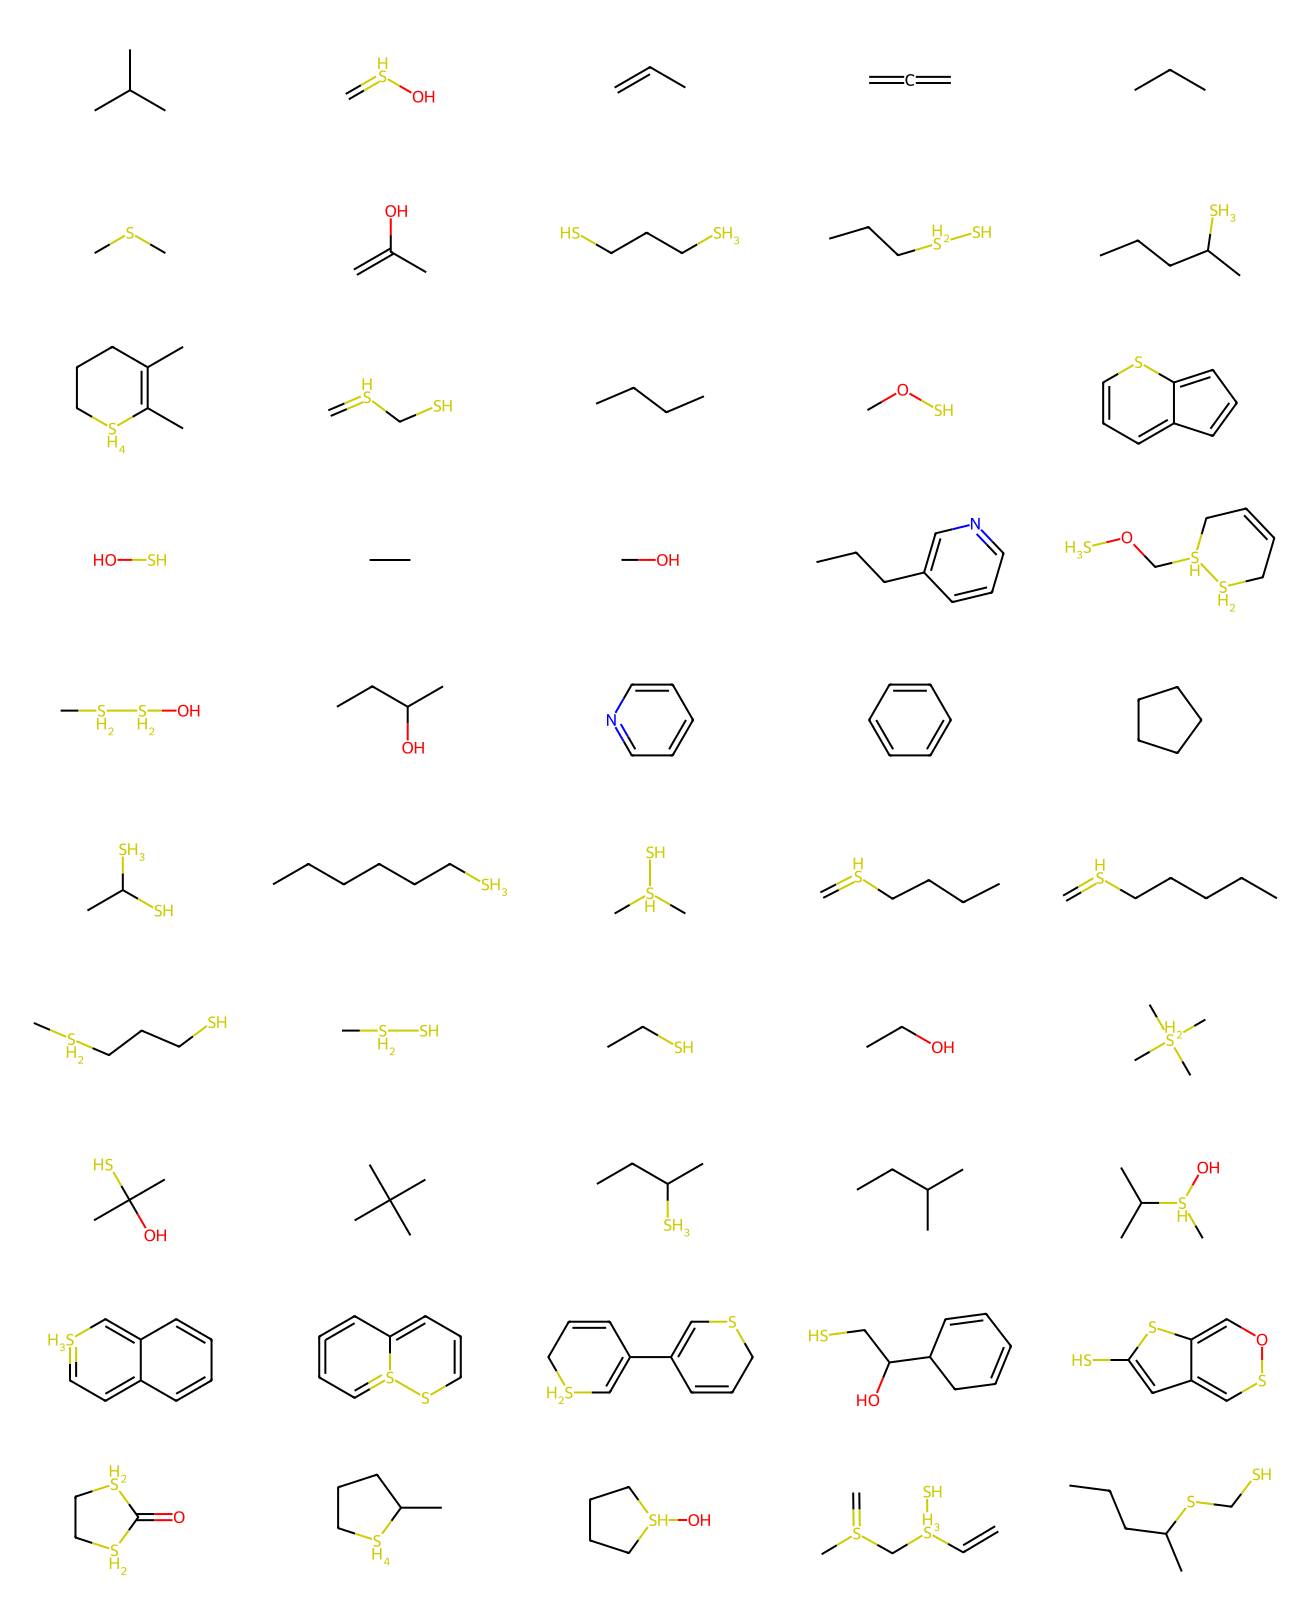

In [23]:
from rdkit.Chem.Draw import MolsToGridImage


unique_smiles = set()
unique_molecules = []

for mol in valid_molecules:
    smiles = Chem.MolToSmiles(mol,canonical=True)
    if smiles not in unique_smiles:
        unique_smiles.add(smiles)
        unique_molecules.append(mol)

grid_image = MolsToGridImage(
    unique_molecules, molsPerRow=5, subImgSize=(260, 160)
)

grid_image

In [24]:
def smiles_to_canonical(smiles_list):
    canonical_smiles = []
    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)  
        if mol is not None:
            canonical_smile = Chem.MolToSmiles(mol, canonical=True)  
            canonical_smiles.append(canonical_smile)
        else:
            canonical_smiles.append(None)  
    return canonical_smiles

In [25]:

original_dataset = smiles_to_canonical(pd.read_csv(r'C:\Users\sarab\OneDrive\Desktop\CSIR\generative_model_compare\data\curated dataset\curated_GS_LF_merged_cleaned.csv').iloc[:, 0].tolist())
generated_smiles_canonical = smiles_to_canonical(generated_smiles)


valid_generated_smiles_canonical = [smile for smile in generated_smiles_canonical if smile is not None]
generated_smiles=valid_generated_smiles_canonical
print(len(original_dataset))
print(len(generated_smiles))

4751
490


In [26]:

valid_generated_smiles = [smiles for smiles in generated_smiles if is_strictly_valid_smiles(smiles)]
valid_original_smiles = [smiles for smiles in original_dataset if is_strictly_valid_smiles(smiles)]

print("Percent of valid in original :" ,len(valid_original_smiles)/len(original_dataset))
print("Percent of valid in generated :" ,len(valid_generated_smiles)/len(generated_smiles))

Percent of valid in original : 1.0
Percent of valid in generated : 1.0


In [27]:
# Function created to remove SMILES present in valid_original_smiles from valid_generated_smiles
def filter_generated_smiles(valid_generated_smiles, valid_original_smiles):
    
    
    set_generated = set(valid_generated_smiles)
    set_original = set(valid_original_smiles)
    
    
    filtered_set = set_generated - set_original
    
    
    filtered_list = list(filtered_set)
    
    return filtered_list

In [28]:
filtered_generated_smiles = filter_generated_smiles(valid_generated_smiles, valid_original_smiles)
print("Filtered Generated SMILES:", len(filtered_generated_smiles))

Filtered Generated SMILES: 461


In [29]:
import requests
import pandas as pd
def check_in_pubchem(smiles):
    """
    Checks if the given SMILES string is in PubChem using the PUG-REST API.
    Returns True if the SMILES is found in PubChem, False otherwise.
    
    Args:
        smiles (str): A SMILES string representing a chemical compound
        
    Returns:
        bool: True if found in PubChem, False otherwise
    """
    
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/cids/TXT"
    response = requests.get(url)
    
    
    if response.status_code == 200 and response.text.strip():
        return True
    return False

In [30]:
from tqdm import tqdm

def filter_pubchem_smiles(smiles_list):
    """
    Filter a list of SMILES strings to keep only those found in PubChem.
    
    Args:
        smiles_list (list): List of SMILES strings to check
        
    Returns:
        list: Filtered list containing only SMILES found in PubChem
    """
    filtered_smiles = []
    
    for smile in tqdm(smiles_list, desc="Checking PubChem"):
        try:
            if check_in_pubchem(smile):
                filtered_smiles.append(smile)
        except Exception as e:
            print(f"Error checking SMILES {smile}: {str(e)}")
            continue
            
    return filtered_smiles


In [31]:
print("Count before PubChem:", len(filtered_generated_smiles))
filtered_generated_smiles = filter_pubchem_smiles(filtered_generated_smiles)
print('Count after Pubchem:' ,len(filtered_generated_smiles))

Count before PubChem: 461


Checking PubChem: 100%|██████████| 461/461 [09:46<00:00,  1.27s/it]

Count after Pubchem: 140


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


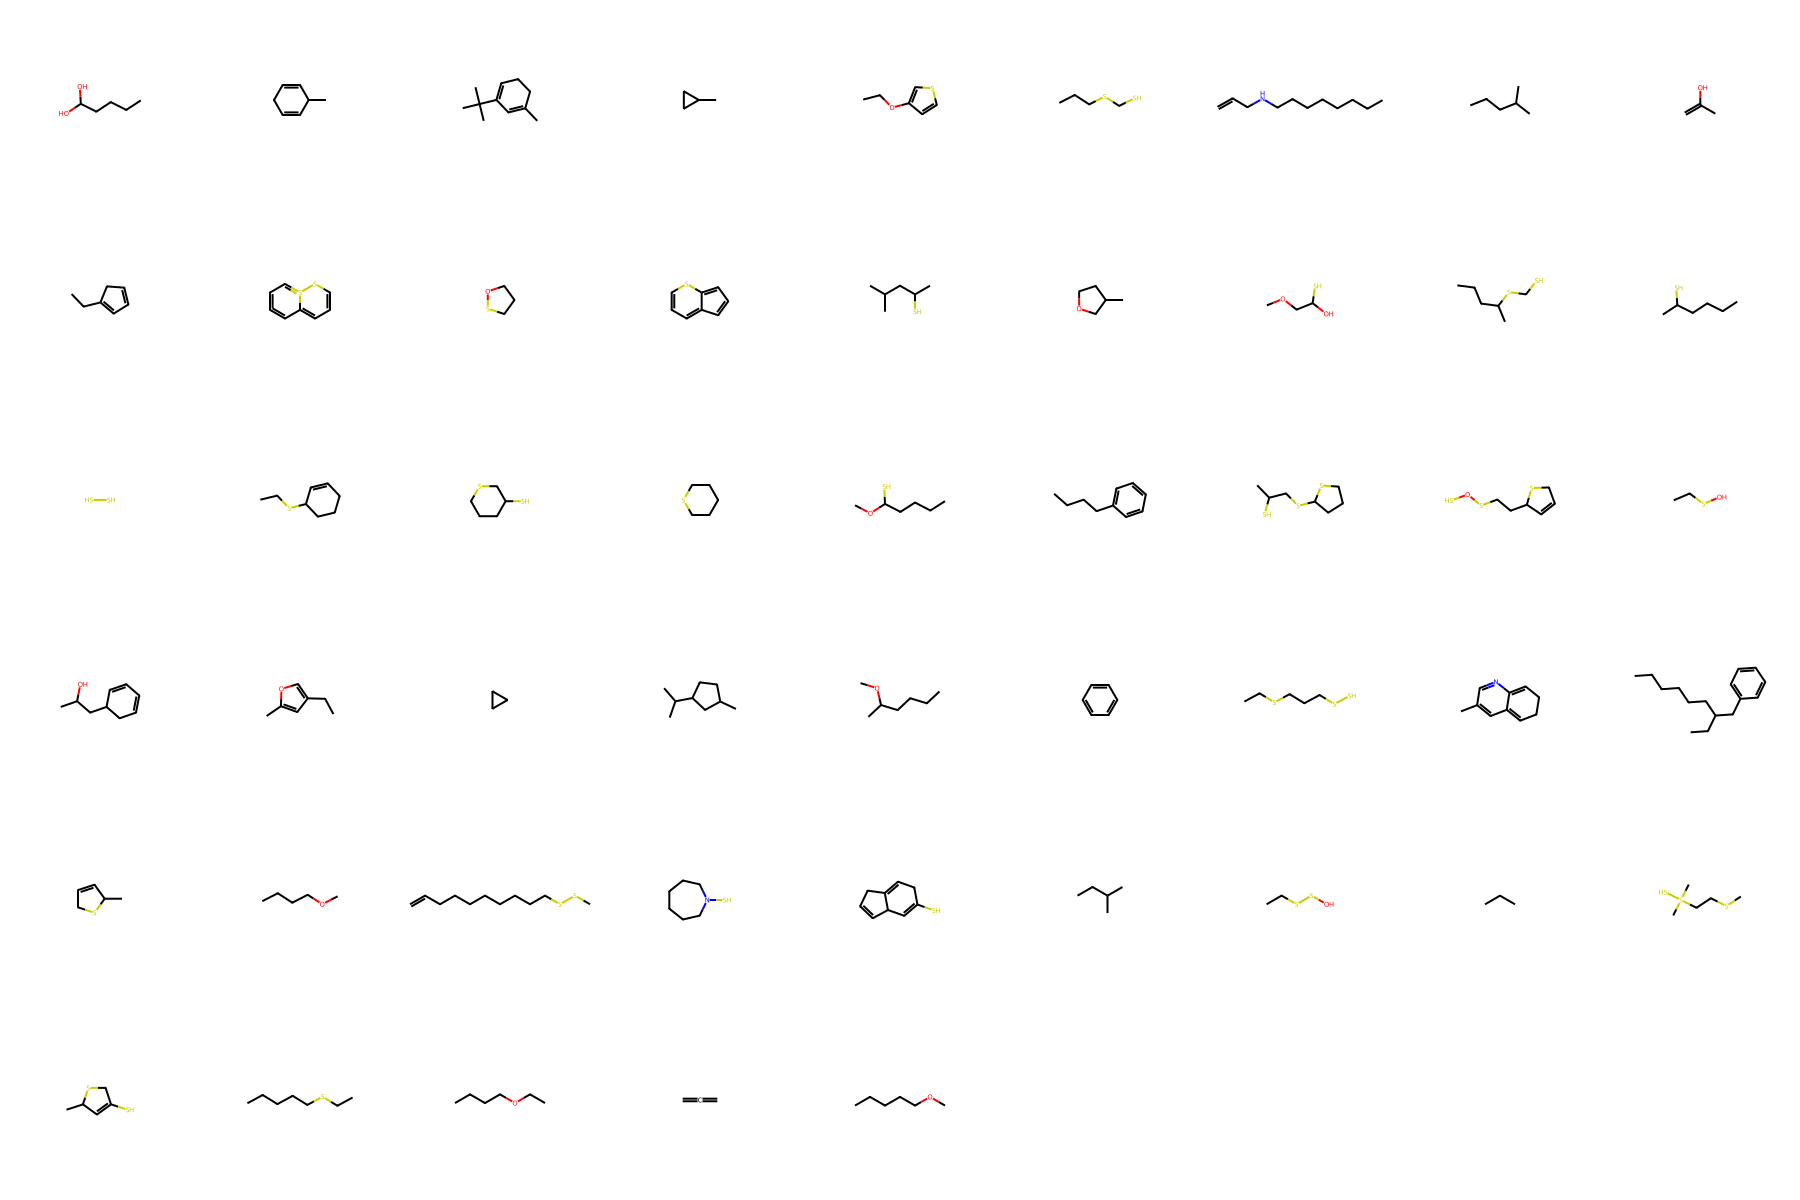

In [32]:
from rdkit.Chem import Draw
import io
from PIL import Image
from io import BytesIO

mols = [Chem.MolFromSmiles(smiles) for smiles in filtered_generated_smiles[:60]]
img = Draw.MolsToGridImage(mols, molsPerRow=9, subImgSize=(200, 200))


img

In [33]:
import csv


data_list = filtered_generated_smiles

file_name = "../../data/ARGA/filtered_generated_smiles.csv"
with open(file_name, mode="w", newline="") as file:
    writer = csv.writer(file)
    
    
    writer.writerow(["SMILE"])
    
    
    for item in data_list:
        writer.writerow([item])

print(f"List saved to {file_name} with the first column named 'SMILE'")
print("Files created:")
print(f"1. filtered_generated_smiles.csv")

List saved to ../../data/ARGA/filtered_generated_smiles.csv with the first column named 'SMILE'
Files created:
1. filtered_generated_smiles.csv


In [34]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import numpy as np
from tqdm import tqdm  
import pandas as pd

def calculate_diversity(smiles_list):
    """
    Calculate the diversity score for a list of SMILES strings.

    Parameters:
    - smiles_list: List of SMILES strings.

    Returns:
    - diversity_score: A value representing the diversity of the dataset.
    """
    try:
        
        fingerprints = []
        for smiles in tqdm(smiles_list, desc="Generating fingerprints"):
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
                fingerprints.append(fp)
            else:
                print(f"Invalid SMILES skipped: {smiles}")
        
        
        num_fps = len(fingerprints)
        if num_fps < 2:
            print("Not enough valid molecules to calculate diversity.")
            return 0.0

        similarities = []
        for i in tqdm(range(num_fps), desc="Calculating similarities"):
            for j in range(i + 1, num_fps):
                sim = DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
                similarities.append(sim)

        
        avg_similarity = np.mean(similarities) if similarities else 1.0
        diversity_score = 1 - avg_similarity

        return diversity_score

    except Exception as e:
        print(f"Error calculating diversity: {e}")
        return None

file11_path = "../../data/ARGA/filtered_generated_smiles.csv"
column11 = "SMILE"  


df = pd.read_csv(file11_path)


smiles_list = df[column11].tolist()

diversity = calculate_diversity(smiles_list)
print(f"Diversity Score: {diversity:.4f}")

Calculating similarities: 100%|██████████| 140/140 [00:00<00:00, 4417.45it/s]

Diversity Score: 0.9132


In [35]:

num_valid_generated = len(valid_generated_smiles)
total_generated = len(generated_smiles)
valid_generated_percentage = (num_valid_generated / total_generated) * 100

unique_generated = set(valid_generated_smiles)
num_unique_generated = len(unique_generated)
unique_generated_percentage = (num_unique_generated / num_valid_generated) * 100


unique_valid = set(valid_generated_smiles)
num_unique_valid = len(unique_valid)

unique_valid_percentage = (num_unique_valid / num_valid_generated * 100) if num_valid_generated > 0 else 0


num_valid_original = len(valid_original_smiles)
total_original = len(original_dataset)
valid_original_percentage = (num_valid_original / total_original) * 100


unique_original = set(original_dataset)
num_unique_original = len(unique_original)
unique_original_percentage = (num_unique_original / total_original) * 100


results = {
    "Metric": [
        "Percentage of valid SMILES (Generated)", 
        "Percentage of unique SMILES (Generated)", 
        "Percentage of unique SMILES among valid (Generated)", 
        "Number of valid SMILES (Generated)", 
        "Number of unique SMILES (Generated)", 
        "Number of unique SMILES among valid (Generated)",
        "Percentage of valid SMILES (Original)", 
        "Percentage of unique SMILES (Original)",
        "Diversity Score: Generated"
    ],
    "Value": [
        f"{valid_generated_percentage:.2f}%", 
        f"{unique_generated_percentage:.2f}%", 
        f"{unique_valid_percentage:.2f}%", 
        num_valid_generated, 
        num_unique_generated, 
        num_unique_valid,
        f"{valid_original_percentage:.2f}%", 
        f"{unique_original_percentage:.2f}%",
        f"{diversity:.4f}"
    ]
}


df_results = pd.DataFrame(results)


output_file = '../../data/ARGA/generated_molecules_metrics_comparision.xlsx'
df_results.to_excel(output_file, index=False)

print(f"Results have been saved to {output_file}")


print(df_results)

Results have been saved to ../../data/ARGA/generated_molecules_metrics_comparision.xlsx
                                              Metric    Value
0             Percentage of valid SMILES (Generated)  100.00%
1            Percentage of unique SMILES (Generated)   99.80%
2  Percentage of unique SMILES among valid (Gener...   99.80%
3                 Number of valid SMILES (Generated)      490
4                Number of unique SMILES (Generated)      489
5    Number of unique SMILES among valid (Generated)      489
6              Percentage of valid SMILES (Original)  100.00%
7             Percentage of unique SMILES (Original)  100.00%
8                         Diversity Score: Generated   0.9132


In [36]:
# function to check if the molecule is fragrant as per "GDB Criteria"
#Mayhew, Emily J., et al. "Transport features predict if a molecule is odorous."
#  Proceedings of the National Academy of Sciences
def is_fragrant(smiles, hac_threshold=17, allowed_atoms=None):
 
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hac = Descriptors.HeavyAtomCount(mol)
        if hac <= hac_threshold:
            atoms = set(atom.GetSymbol() for atom in mol.GetAtoms())
            return atoms.issubset(allowed_atoms)
    return False


In [37]:
"""Ruddigkeit et al. Enumeration of 166 billion organic
small molecules in the chemical universe database GDB-17. J. Chem. Inf. Model
 developed GDB-17, a database of
166 billion unique molecules with heavy atom count (HAC) of
17 or fewer. While it excludes some known odorants (e.g.,
silica-containing molecules), the composition of this database of
small organic molecules (limited to atoms C, H, N, O, S, F, Cl,
Br, and I; HAC ≤ 17; unstable structures eliminated)"""
import pandas as pd
def fragrant_statistics(filtered_generated_smiles, hac_threshold=17, allowed_atoms=None):
    

    if allowed_atoms is None:
        allowed_atoms = {'C', 'H', 'N', 'O', 'S', 'F', 'Cl', 'Br', 'I'}
    
    fragrant_smiles = [s for s in filtered_generated_smiles if is_fragrant(s, hac_threshold, allowed_atoms)]
    
    fragrant_count = len(fragrant_smiles)
    fragrant_unique_count = len(set(fragrant_smiles))

    set_frag_generated = set(fragrant_smiles)
    set_frag_original = set(valid_original_smiles)
    
    novel_frag_set = set_frag_generated - set_frag_original  
    novel_non_frag_set= set(filtered_generated_smiles) -  novel_frag_set
    total_valid = len(valid_generated_smiles)
    unique_valid = len(set(valid_generated_smiles))

    percentage_fragrant = (fragrant_count / total_valid * 100) if total_valid > 0 else 0
    percentage_unique_fragrant = (len(novel_frag_set) / unique_valid * 100) if unique_valid > 0 else 0
    pd.DataFrame(list(novel_frag_set), columns=['SMILES']).to_csv('../../data/ARGA/GDB Criteria/novel_ARGA_frag_set.csv', index=False)
    pd.DataFrame(list(novel_non_frag_set), columns=['SMILES']).to_csv('../../data/ARGA/GDB Criteria/novel_ARGA_non_frag_set.csv', index=False)
    return fragrant_count, percentage_fragrant, percentage_unique_fragrant

In [38]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import QED, Crippen, Descriptors, rdMolDescriptors, AllChem
from rdkit.Chem.Descriptors import MolWt

def get_bond_length(conformer, atom1_idx, atom2_idx):
    """Calculate the bond length between two atoms in a conformer."""
    pos1 = conformer.GetAtomPosition(atom1_idx)
    pos2 = conformer.GetAtomPosition(atom2_idx)
    return (pos1 - pos2).Length()

def calculate_properties(smiles_list):
    properties = []

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Compute Gasteiger charges
            AllChem.ComputeGasteigerCharges(mol)
            conf = mol.GetConformer() if mol.GetNumConformers() > 0 else None
            
            basic_props = {
                'QED': QED.qed(mol),
                'logP': Crippen.MolLogP(mol),
                'Molecular Weight': Descriptors.MolWt(mol),
                'Number of Heavy Atoms': Descriptors.HeavyAtomCount(mol),
                'TPSA': Descriptors.TPSA(mol),
                'Rotatable Bonds': Descriptors.NumRotatableBonds(mol),
                'H-bond Donors': Descriptors.NumHDonors(mol),
                'H-bond Acceptors': Descriptors.NumHAcceptors(mol),
                'Ring Count': Descriptors.RingCount(mol),
                'Formal Charge': Chem.GetFormalCharge(mol),
                'Fraction of Sp2 Hybridized Atoms': rdMolDescriptors.CalcFractionCSP3(mol),
                'Number of Aromatic Rings': rdMolDescriptors.CalcNumAromaticRings(mol),
                'Hydrophobic Surface Area': Descriptors.TPSA(mol) - Descriptors.NumHAcceptors(mol) * 0.2,
                'Molar Refractivity': Descriptors.MolMR(mol),
                'Rotatable Bond Count': Descriptors.NumRotatableBonds(mol),
                'Number of Heteroatoms': rdMolDescriptors.CalcNumHeteroatoms(mol),
                'Ipc': Descriptors.Ipc(mol),
                'Kappa1': Descriptors.Kappa1(mol),
                'Kappa2': Descriptors.Kappa2(mol),
                'Kappa3': Descriptors.Kappa3(mol),
                'LabuteASA': Descriptors.LabuteASA(mol),
                'PEOE_VSA1': Descriptors.PEOE_VSA1(mol),
                'PEOE_VSA2': Descriptors.PEOE_VSA2(mol),
                'PEOE_VSA3': Descriptors.PEOE_VSA3(mol),
                'SMR_VSA1': Descriptors.SMR_VSA1(mol),
                'SMR_VSA2': Descriptors.SMR_VSA2(mol),
                'SMR_VSA3': Descriptors.SMR_VSA3(mol),
                'SlogP_VSA1': Descriptors.SlogP_VSA1(mol),
                'SlogP_VSA2': Descriptors.SlogP_VSA2(mol),
                'SlogP_VSA3': Descriptors.SlogP_VSA3(mol),
                'FCFP4 Count': len(AllChem.GetMorganFingerprintAsBitVect(mol, 2, useFeatures=True).GetOnBits()),
                'ECFP4 Count': len(AllChem.GetMorganFingerprintAsBitVect(mol, 2, useFeatures=False).GetOnBits()),
                'Num Bridgehead Atoms': rdMolDescriptors.CalcNumBridgeheadAtoms(mol),
                'Num Spiro Atoms': rdMolDescriptors.CalcNumSpiroAtoms(mol),
                'Num Macrocycles': sum(1 for ring in mol.GetRingInfo().AtomRings() if len(ring) > 8),
                'Fsp3': rdMolDescriptors.CalcFractionCSP3(mol),
                'Ring Atom Count': sum(1 for atom in mol.GetAtoms() if atom.IsInRing()),
                'Ring Bond Count': sum(1 for bond in mol.GetBonds() if bond.IsInRing()),
                'Aliphatic Ring Count': rdMolDescriptors.CalcNumAliphaticRings(mol),
                'Aliphatic Heteroatom Count': sum(1 for atom in mol.GetAtoms() if atom.IsInRing() and atom.GetAtomicNum() not in [1, 6]),
                'Aromatic Heteroatom Count': sum(1 for atom in mol.GetAtoms() if atom.GetIsAromatic() and atom.GetAtomicNum() not in [1, 6]),
                'Saturated Ring Count': rdMolDescriptors.CalcNumSaturatedRings(mol),
                'Aromatic Ring Count': rdMolDescriptors.CalcNumAromaticRings(mol),
                'Heteroatom Count': sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() not in [1, 6]),
                'Hetero-Aliphatic Ring Count': rdMolDescriptors.CalcNumAliphaticHeterocycles(mol),
                'Hetero-Aromatic Ring Count': rdMolDescriptors.CalcNumAromaticHeterocycles(mol),
                'Hetero-Saturated Ring Count': rdMolDescriptors.CalcNumSaturatedHeterocycles(mol),
                'Largest Ring Size': max([len(ring) for ring in mol.GetRingInfo().AtomRings()]) if mol.GetRingInfo().AtomRings() else 0,
                'Mannhold LogP': Crippen.MolLogP(mol),
                'Wildman-Crippen MR': Crippen.MolMR(mol),
                'Average Molecular Weight': Descriptors.MolWt(mol) / mol.GetNumAtoms(),
                'Exact Molecular Weight': Descriptors.ExactMolWt(mol),
                'Polar Surface Area': Descriptors.TPSA(mol),
                'Atom Pair Fingerprint Count': len(AllChem.GetAtomPairFingerprint(mol).GetNonzeroElements()),
                
                'Natural Product Likeness Score': QED.qed(mol),  # Placeholder for NP-likeness
            }
            
            properties.append(basic_props)
        else:
            null_props = {key: None for key in basic_props.keys()}
            properties.append(null_props)
    
    return properties

def calculate_averages(properties):
    sums = {key: 0 for key in properties[0].keys()}
    counts = {key: 0 for key in properties[0].keys()}

    for prop in properties:
        for key, value in prop.items():
            if isinstance(value, (int, float)) and value is not None:
                sums[key] += value
                counts[key] += 1

    averages = {key: (sums[key] / counts[key] if counts[key] > 0 else None) for key in sums.keys()}
    return averages

def calculate_novelty(valid_generated_smiles, valid_original_smiles):
    set_generated = set(valid_generated_smiles)
    set_original = set(valid_original_smiles)
    
    novel_set = set_generated - set_original
    total_generated = len(set_generated)
    novel_count = len(novel_set)
    novelty_percentage = (novel_count / len(set_generated) * 100) if set_generated else 0
    
    novel_list = list(novel_set)
    
    return novelty_percentage, novel_list

def print_averages_as_table(averages, fragrant_count, percentage_fragrant, percentage_unique_fragrant, novelty_percentage):
    df = pd.DataFrame(list(averages.items()), columns=['Descriptor', 'Average Value'])
    
    additional_data = [
        {'Descriptor': 'Generated Valid SMILES (Fragrant Count)', 'Average Value': f"{fragrant_count}"},
        {'Descriptor': 'Generated Valid SMILES (Percentage Fragrant)', 'Average Value': f"{percentage_fragrant:.2f}%"},
        {'Descriptor': 'Generated Valid SMILES (Percentage Unique Fragrant)', 'Average Value': f"{percentage_unique_fragrant:.2f}%"},
        {'Descriptor': 'Generated Valid SMILES (Novelty Percentage)', 'Average Value': f"{novelty_percentage:.2f}%"}
    ]
    
    additional_df = pd.DataFrame(additional_data)
    
    df = pd.concat([df, additional_df], ignore_index=True)
    
    def format_value(value):
        if isinstance(value, float):
            return f"{value:.2f}"
        return value

    df['Average Value'] = df['Average Value'].apply(format_value)
    print(df.to_string(index=False, justify='left', line_width=100))
 

if __name__ == "__main__":


    
    props = calculate_properties(valid_generated_smiles)
    
    
    averages = calculate_averages(props)
    
    
    fragrant_count, percentage_fragrant, percentage_unique_fragrant = fragrant_statistics(filtered_generated_smiles)
    
    
    novelty_percentage, _ = calculate_novelty(valid_generated_smiles, valid_original_smiles)
    
    
    print_averages_as_table(averages, fragrant_count, percentage_fragrant, percentage_unique_fragrant, novelty_percentage)

Descriptor                                          Average Value
                                                QED   0.47       
                                               logP   1.74       
                                   Molecular Weight 142.42       
                              Number of Heavy Atoms   7.73       
                                               TPSA   5.49       
                                    Rotatable Bonds   2.48       
                                      H-bond Donors   0.70       
                                   H-bond Acceptors   0.98       
                                         Ring Count   0.43       
                                      Formal Charge   0.00       
                   Fraction of Sp2 Hybridized Atoms   0.81       
                           Number of Aromatic Rings   0.05       
                           Hydrophobic Surface Area   5.29       
                                 Molar Refractivity  44.65       
          

In [39]:
import pandas as pd

def save_averages_as_csv(averages, fragrant_count, percentage_fragrant, percentage_unique_fragrant, novelty_percentage, filename="../data/ARGA/generated_mol_propertiess_average.csv"):
    df = pd.DataFrame(list(averages.items()), columns=['Descriptor', 'Average Value'])   
    additional_data = [
        {'Descriptor': 'Generated Valid SMILES (Fragrant Count)', 'Average Value': f"{fragrant_count}"},
        {'Descriptor': 'Generated Valid SMILES (Percentage Fragrant)', 'Average Value': f"{percentage_fragrant:.2f}%"},
        {'Descriptor': 'Generated Valid SMILES (Percentage Unique Fragrant)', 'Average Value': f"{percentage_unique_fragrant:.2f}%"},
        {'Descriptor': 'Generated Valid SMILES (Novelty Percentage)', 'Average Value': f"{novelty_percentage:.2f}%"}
    ]
    
    additional_df = pd.DataFrame(additional_data)
    
    df = pd.concat([df, additional_df], ignore_index=True)
    
    def format_value(value):
        if isinstance(value, float):
            return f"{value:.2f}"
        return value

    df['Average Value'] = df['Average Value'].apply(format_value)
    
    
    df.to_csv('../../data/ARGA/GDB Criteria/average_molecular_properties.csv', index=False)
    
    print(f"Averages and statistics saved to {filename}")


save_averages_as_csv(averages, fragrant_count, percentage_fragrant, percentage_unique_fragrant, novelty_percentage)

Averages and statistics saved to ../data/ARGA/generated_mol_propertiess_average.csv


In [40]:

import pandas as pd
from rdkit import Chem
from rdkit.Chem import QED, Crippen, Descriptors, rdMolDescriptors, AllChem
from rdkit.Chem.Descriptors import MolWt

# Function to calculate molecular properties
def calculate_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None
    try:
        logP = Crippen.MolLogP(mol)
        mol_weight = Descriptors.MolWt(mol) / 1000  # Scaling for the equation
        slogp_vsa3 = Descriptors.SlogP_VSA3(mol)
        fraction_sp2 = rdMolDescriptors.CalcFractionCSP3(mol)
        fcfp4_count = len(AllChem.GetMorganFingerprintAsBitVect(mol, 2, useFeatures=True).GetOnBits())
        return [logP, mol_weight, slogp_vsa3, fraction_sp2, fcfp4_count]
    except Exception as e:
        print(f"Error processing SMILES: {smiles}, Error: {e}")
        return None

# Function to calculate frag_likeliness
def calculate_frag_likeliness(properties, intercept, coefficients):
    if properties is None:
        return None
    frag_likeliness = intercept
    for coef, prop in zip(coefficients, properties):
        frag_likeliness += coef * prop
    return 1 if frag_likeliness >= 0 else 0

# Define coefficients and intercept from the logistic regression equation
intercept = -3.6592482454788144
coefficients = [ 7.07707381, -6.28106569,  1.1403281 ,  0.58692161,  1.92618175]


df = pd.read_csv("../../data/ARGA/filtered_generated_smiles.csv")


results = []
for smiles in df["SMILE"]:
    properties = calculate_properties(smiles)
    frag_likeliness = calculate_frag_likeliness(properties, intercept, coefficients)
    results.append(frag_likeliness)


df["frag_likeliness"] = results
df.to_csv("../../data/ARGA/logistic equation/filtered_gen_with_frag_likeliness.csv", index=False)

print("Processed data saved to 'filtered_gen_with_frag_likeliness.csv'.")
print("Files created:")
print("1. filtered_gen_with_frag_likeliness.csv")


Processed data saved to 'filtered_gen_with_frag_likeliness.csv'.
Files created:
1. filtered_gen_with_frag_likeliness.csv


In [41]:

df = pd.read_csv("../../data/ARGA/logistic equation/filtered_gen_with_frag_likeliness.csv")


novel_odorrous_set = df[df["frag_likeliness"] == 1]
novel_odorless_set = df[df["frag_likeliness"] == 0]


novel_odorrous_set.to_csv("../../data/ARGA/logistic equation/novel_odorrous_set_log_eq.csv", index=False)
novel_odorless_set.to_csv("../../data/ARGA/logistic equation/novel_odorless_set_log_eq.csv", index=False)

print(f"Total molecules: {len(df)}")
print(f"Fragment molecules: {len(novel_odorrous_set)}")
print(f"Non-fragment molecules: {len(novel_odorless_set)}")
print("Files created:")
print("1. novel_odorrous_set_log_eq.csv (frag_likeliness = 1)")
print("2. novel_odorless_set_log_eq.csv (frag_likeliness = 0)")

Total molecules: 140
Fragment molecules: 140
Non-fragment molecules: 0
Files created:
1. novel_odorrous_set_log_eq.csv (frag_likeliness = 1)
2. novel_odorless_set_log_eq.csv (frag_likeliness = 0)


In [42]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

def calculate_frag_likeliness_Rule3(smiles):
    """
    Calculate fragment likeliness based on molecular weight and heteroatom count.
    
    Args:
        smiles (str): SMILES string of the molecule
    
    Returns:
        int: 1 if meets criteria, 0 otherwise
    """
    mol = Chem.MolFromSmiles(smiles)
    
    
    if mol is None:
        return 0
    
    
    mol_weight = Descriptors.ExactMolWt(mol)
    
    
    heteroatom_count = len([atom for atom in mol.GetAtoms() if atom.GetAtomicNum() not in [6, 1]])

    
    if 30 <= mol_weight <= 300 and heteroatom_count < 3:
        return 1
    else:
        return 0


df = pd.read_csv('../../data/ARGA/filtered_generated_smiles.csv')


df['frag_likeliness'] = df['SMILE'].apply(calculate_frag_likeliness_Rule3)


df.to_csv('../../data/ARGA/rule of three/filtered_gen_with_frag_likeliness.csv', index=False)


frag_set = df[df['frag_likeliness'] == 1]
non_frag_set = df[df['frag_likeliness'] == 0]


frag_set.to_csv('../../data/ARGA/rule of three/novel_ARGA_frag_set.csv', index=False)
non_frag_set.to_csv('../../data/ARGA/rule of three/novel_ARGA_non_frag_set.csv', index=False)

print(f"Total molecules: {len(df)}")
print(f"Fragment molecules: {len(frag_set)}")
print(f"Non-fragment molecules: {len(non_frag_set)}")

print("Processing complete. Output file saved.")


Total molecules: 140
Fragment molecules: 123
Non-fragment molecules: 17
Processing complete. Output file saved.


In [43]:
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors

def is_fragrance_like(smiles):
    
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return 0
    
    
    hac = mol.GetNumHeavyAtoms()
    if hac > 21:
        return 0
    
    
    allowed_atoms = {6, 1, 8, 16}  # C, H, O, S
    atom_types = set(atom.GetAtomicNum() for atom in mol.GetAtoms())
    if not all(atom in allowed_atoms for atom in atom_types):
        return 0
    
    
    heteroatom_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() in {8, 16})
    if heteroatom_count > 3:
        return 0
    
    # Counting hydrogen bond donors
    hbd = Descriptors.NumHDonors(mol)
    if hbd > 1:
        return 0
    
    return 1


df = pd.read_csv('../../data/ARGA/filtered_generated_smiles.csv')


df['frag_likeliness'] = df['SMILE'].apply(is_fragrance_like)


df.to_csv('../../data/ARGA/fragrance_like_property/filtered_gen_with_frag_likeliness.csv', index=False)


novel_frag_set = df[df['frag_likeliness'] == 1]
novel_non_frag_set = df[df['frag_likeliness'] == 0]

novel_frag_set.to_csv('../../data/ARGA/fragrance_like_property/novel_ARGA_frag_set.csv', index=False)
novel_non_frag_set.to_csv('../../data/ARGA/fragrance_like_property/novel_ARGA_non_frag_set.csv', index=False)

print(f"Total molecules: {len(df)}")
print(f"Fragrance-like molecules: {len(novel_frag_set)}")
print(f"Non-fragrance-like molecules: {len(novel_non_frag_set)}")

Total molecules: 140
Fragrance-like molecules: 121
Non-fragrance-like molecules: 19


In [44]:
import pandas as pd
Total_molecules = len(pd.read_csv('../../data/ARGA/fragrance_like_property/filtered_gen_with_frag_likeliness.csv'))

count_frag_GDB = len(pd.read_csv('../../data/ARGA/GDB Criteria/novel_ARGA_frag_set.csv'))
count_frag_rule_three = len(pd.read_csv('../../data/ARGA/rule of three/novel_ARGA_frag_set.csv'))
count_frag_fl = len(pd.read_csv('../../data/ARGA/fragrance_like_property/novel_ARGA_frag_set.csv'))
count_frag_logistical = len(pd.read_csv("../../data/ARGA/logistic equation/novel_odorrous_set_log_eq.csv"))

print("Total molecule generated:" , Total_molecules)
print("Fragrant molecules generated from GDB: " ,count_frag_GDB/Total_molecules * 100)
print("Fragrant molecules generated from Rule of three: ", count_frag_rule_three/Total_molecules *100)
print("Fragrant molecules generated from FL Criteria: ", count_frag_fl / Total_molecules * 100)
print("Fragrant molecules generated from Logistical Regression: " , count_frag_logistical/Total_molecules  * 100)



Total molecule generated: 140
Fragrant molecules generated from GDB:  100.0
Fragrant molecules generated from Rule of three:  87.85714285714286
Fragrant molecules generated from FL Criteria:  86.42857142857143
Fragrant molecules generated from Logistical Regression:  100.0


In [45]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import Counter
import numpy as np

def calculate_scaffold_similarity(ref_smiles, gen_smiles):
    """
    Calculate scaffold similarity between reference and generated SMILES lists.
    
    Args:
        ref_smiles (list): List of SMILES strings from reference set
        gen_smiles (list): List of SMILES strings from generated set
    
    Returns:
        float: Scaffold similarity score between 0 and 1
    """
    
    def get_scaffold(smiles):
        """Extract Murcko scaffold from a SMILES string."""
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return None
            scaffold = MurckoScaffold.GetScaffoldForMol(mol)
            scaffold_smiles = Chem.MolToSmiles(scaffold, canonical=True)
            return scaffold_smiles
        except:
            return None
    
    
    ref_scaffolds = [get_scaffold(s) for s in ref_smiles]
    gen_scaffolds = [get_scaffold(s) for s in gen_smiles]
    
    
    ref_scaffolds = [s for s in ref_scaffolds if s is not None]
    gen_scaffolds = [s for s in gen_scaffolds if s is not None]
    
    if len(ref_scaffolds) == 0 or len(gen_scaffolds) == 0:
        return 0.0
    
    
    ref_counts = Counter(ref_scaffolds)
    gen_counts = Counter(gen_scaffolds)
    
    
    ref_unique = set(ref_scaffolds)
    gen_unique = set(gen_scaffolds)
    
    
    ref_freq = {scaffold: count/len(ref_scaffolds) for scaffold, count in ref_counts.items()}
    gen_freq = {scaffold: count/len(gen_scaffolds) for scaffold, count in gen_counts.items()}
    
    
    common_scaffolds = ref_unique.intersection(gen_unique)
    

    similarity = 0
    for scaffold in common_scaffolds:
        similarity += min(ref_freq[scaffold], gen_freq[scaffold])
    
    return similarity

c1 = 'nonStereoSMILES'
data = pd.read_csv(r'C:\Users\sarab\OneDrive\Desktop\CSIR\generative_model_compare\data\curated dataset\curated_GS_LF_merged_cleaned.csv')
column_data = data[c1]

print("Scaffold Similarity:" ,calculate_scaffold_similarity(ref_smiles= column_data, gen_smiles = filtered_generated_smiles ) )

Scaffold Similarity: 0.5468938870012329


In [46]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np

def calculate_snn(ref_smiles, gen_smiles, radius=2, n_bits=1024):
    """
    Calculate Similarity to Nearest Neighbor (SNN) between reference and generated SMILES lists.
    
    Args:
        ref_smiles (list): List of SMILES strings from reference set
        gen_smiles (list): List of SMILES strings from generated set
        radius (int): Radius for Morgan fingerprint generation
        n_bits (int): Number of bits in fingerprints
    
    Returns:
        float: Average similarity to nearest neighbor
    """
    
    def smiles_to_fingerprint(smiles):
        """Convert SMILES to Morgan fingerprint."""
        
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return None
            return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        except:
            return None
    
    def get_fingerprints(smiles_list):
        """Convert list of SMILES to fingerprints, removing invalid ones."""
        fingerprints = []
        for smiles in smiles_list:
            fp = smiles_to_fingerprint(smiles)
            if fp is not None:
                fingerprints.append(fp)
        return fingerprints
    
    
    ref_fps = get_fingerprints(ref_smiles)
    gen_fps = get_fingerprints(gen_smiles)
    
    if len(ref_fps) == 0 or len(gen_fps) == 0:
        return 0.0
    
    
    similarity_matrix = []
    for gen_fp in gen_fps:
        similarities = []
        for ref_fp in ref_fps:
            sim = DataStructs.TanimotoSimilarity(gen_fp, ref_fp)
            similarities.append(sim)
        similarity_matrix.append(similarities)
    
    similarity_matrix = np.array(similarity_matrix)
    
    
    nearest_neighbor_similarities = np.max(similarity_matrix, axis=1)
    
    
    snn_score = float(np.mean(nearest_neighbor_similarities))
    
    return snn_score

print("Similarity to nearest Neighbour" , calculate_snn(ref_smiles= column_data , gen_smiles = filtered_generated_smiles , radius = 2 , n_bits= 1024))

Similarity to nearest Neighbour 0.45842656148330274
